# Visualização de Informações

Este notebook demonstra o uso do módulo `load_house` para realizar consultas de dados e visualizar informações disponíveis nos data sets REDD e Smart*. São realizadas as seguintes consultas:

1. Consumo instantâneo de múltiplos canais;
2. Consumo instantâneo total;
3. Consumo diário/semanal/mensal de múltiplos canais;
4. Consumo diário/semanal/mensal total;
5. Participação de cada canal no consumo total;
6. Alerta de consumo acima do esperado.

Para todas as consultas, é possível especificar qual o período deseja-se considerar.


In [1]:
import csv
import datetime
import operator
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import load_house

from io import StringIO
from matplotlib import rcParams
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA


# Don't cut xlabel when saving .fig
rcParams.update({'figure.autolayout': True})

# Convert datetime for matplotlib
register_matplotlib_converters()

# Create directory for matplotlib figures
if not os.path.exists('plot/visualizacao'):
    os.makedirs('plot/visualizacao')

# Carregando dados de consumo

Para carregar os dados de consumo, deve-se utilizar as funções `load_house.REDD` ou `load_house.SMART`

In [2]:
help(load_house.SMART)
channels, labels = load_house.SMART('2016')
print(labels['name'])

Help on function SMART in module load_house:

SMART(year)
    Loads data from a SMART dataset house. The 'HomeA' directory must be in the root of the project.
    
    Args:
        year (str): desired year to be loaded.
    
    Returns:
        (list, DataFrame): tuple of a list of each channel consumption data,
        and a DataFrame of the labels identifying the appliance of each channel.

0                      FurnaceHRV
1                   CellarOutlets
2                  WashingMachine
3                     FridgeRange
4              DisposalDishwasher
5                   KitchenLights
6                  BedroomOutlets
7                   BedroomLights
8                   MasterOutlets
9                    MasterLights
10                  DuctHeaterHRV
11                  ElectricRange
12                          Dryer
13            GarageMudroomLights
14              DiningRoomOutlets
15                 MudroomOutlets
16              MasterBathOutlets
17                  Gara

# Consumo instantâneo de múltiplos canais

A cédula a seguir demonstra o uso da função `qry_pot_channel` para informar o consumo de 4 canais no dia 01/01/2016.

É possível alterar o período a ser considerado por meio das variáveis `start_date` e `end_date`.

É possível alterar os canais a serem considerados por meio da variável `select_channels`.

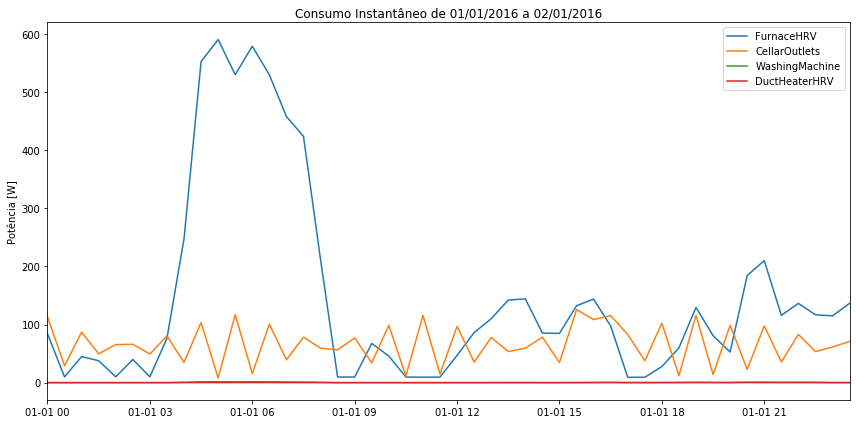

In [3]:
def qry_pot_channel(i_channel, start, end):
    """Runs a query for the potency [W] consumption in a channel in the specified period.
    
    Args:
        i_channel(int): index of the channel.
        start (str): start of the period as "YYYY-MM-DD hh:mm:ss".
        end (str): end of the period as "YYYY-MM-DD hh:mm:ss".
    
    Returns:
        str: csv of the query as [index, time, consumption].
    """
    if i_channel < 0 or i_channel >= len(channels):
        raise Exception('Channel number should be 0-{}. The value was {}'.format(len(labels) - 1, i_channel))
    
    # Select the desired period from channel
    ch = channels[i_channel]
    mask = (ch.t >= start) & (ch.t < end)
    ch_period = ch.loc[mask]
    
    # Return query as csv string
    return ch_period.to_csv()


# Plot data from day 2016-01-01
start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2016-01-02')
#select_channels = range(len(channels))
select_channels = [0, 1, 2, 10]

fig, ax = plt.subplots()
for i in select_channels:
    query = qry_pot_channel(i, start_date, end_date)
    
    # Convert query string to pandas.DataFrame
    ch = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
    ch.t = pd.to_datetime(ch.t)
    
    # Plot query results
    plt.plot(ch.t, ch.pot, label=labels.iloc[i]['name'])

plt.ylabel('Potência [W]')
plt.title('Consumo Instantâneo de {} a {}'.format(start_date.strftime("%d/%m/%Y"), end_date.strftime("%d/%m/%Y")))
plt.legend()
plt.margins(x=0)
fig.set_size_inches(12, 6)
plt.savefig('plot/visualizacao/mult_pot.png')
plt.show()

# Consumo instantâneo total

A cédula a seguir demonstra o uso da função `qry_pot_aggr` para informar o consumo total no dia 01/01/2016.

É possível alterar o período a ser considerado por meio das variáveis `start_date` e `end_date`.

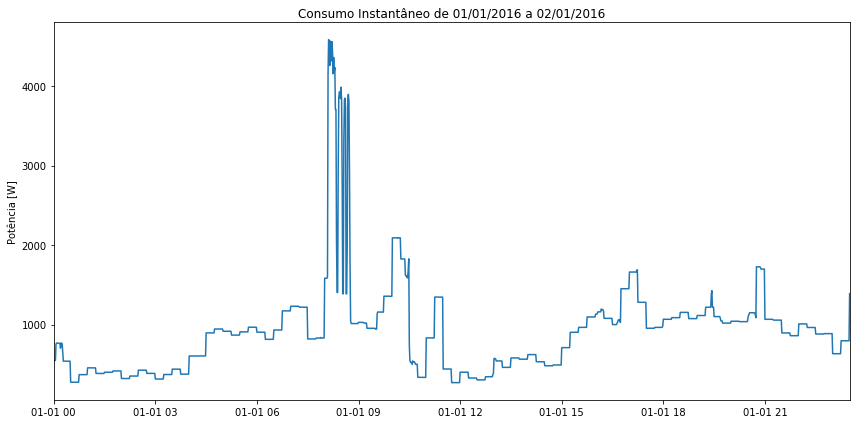

In [4]:
def qry_pot_aggr(start, end, frequency):
    """Runs a query for the aggregated power [W] consumption in all channels in the specified period.
    
    Args:
        start (str): start of the period as "YYYY-MM-DD hh:mm:ss".
        end (str): end of the period as "YYYY-MM-DD hh:mm:ss".
        frequency (int): Frequency of sampling, in minutes.
    
    Returns:
        str: csv of the query as [index, time, consumption].
    """
    periods = (pd.to_datetime(end) - pd.to_datetime(start)) / np.timedelta64(1,'s') / (60 * frequency)
    t = pd.date_range(start, periods=periods, freq='{}min'.format(frequency))
    pot = pd.DataFrame(0, index=np.arange(periods), columns=['pot'])
    aggr_pot = pd.DataFrame([t, pot]).transpose()
    aggr_pot.columns = ['t', 'pot']
    aggr_pot.t = pd.to_datetime(aggr_pot.t)
    aggr_pot.pot = 0
    aggr_pot.index = aggr_pot.t
    
    for i in range(len(channels)):
        # Select the desired period from channel
        ch = channels[i]
        mask = (ch.t >= start) & (ch.t < end)
        ch_period = ch.loc[mask].copy()

        # Convert to desired sampling
        ch_period.index = ch_period.t
        upsample =  ch_period.asfreq(freq='{}min'.format(frequency), method='ffill')
        aggr_pot['pot'] += upsample.pot
    
    # Return query as csv string
    aggr_pot = aggr_pot.reset_index(drop=True)
    return aggr_pot.to_csv()


# Plot data from day 2016-01-01
start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2016-01-02')
freq = 1

# Convert query string to pandas.DataFrame
query = qry_pot_aggr(start_date, end_date, freq)
aggr = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
aggr.t = pd.to_datetime(aggr.t)

fig, ax = plt.subplots()
plt.plot(aggr.t, aggr.pot)
plt.ylabel('Potência [W]')
plt.title('Consumo Instantâneo de {} a {}'.format(start_date.strftime("%d/%m/%Y"), end_date.strftime("%d/%m/%Y")))
plt.margins(x=0)
fig.set_size_inches(12, 6)
plt.savefig('plot/visualizacao/total_pot.png')
plt.show()

# Consumo agregado de múltiplos canais

A cédula a seguir demonstra o uso da função `qry_cons_channel` para informar o consumo diário de 4 canais no mês de janeiro de 2016.

É possível alterar o período a ser considerado por meio das variáveis `start_date` e `end_date`.

É possível alterar a frequência de medição (`'D'`, `'W'`, ou `'M'`) por meio da variável `freq`.

É possível alterar os canais a serem considerados por meio da variável `select_channels`.

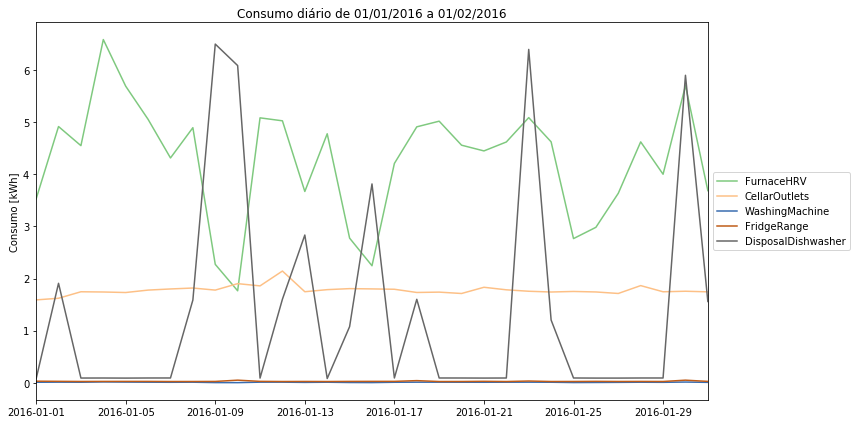

In [5]:
def qry_cons_channel(i_channel, start, end, frequency):
    """Runs a query for the daily/weekly/monthly consumption [kWh] in a channel in the specified period.
    
    Args:
        i_channel (int): index of the channel.
        start (str): start of the period as "YYYY-MM-DD hh:mm:ss".
        end (str): end of the period as "YYYY-MM-DD hh:mm:ss".
        frequency (str): Period of consumption. 'D', 'W', or 'M' (daily, weekly or monthly).
    
    Returns:
        str: csv of the query as [index, date, consumption].
    """
    if i_channel < 0 or i_channel >= len(channels):
        raise Exception('Channel number should be 1-{}. The value was {}'.format(len(labels), i_channel))
    
    # Select the desired period from channel
    ch = channels[i_channel]
    mask = (ch.t >= start) & (ch.t < end)
    ch_period = ch.loc[mask]
    
    # Find mean consumption by day, week, or month
    cons = ch_period.copy()
    cons = cons.set_index('t')
    cons = cons.groupby(pd.Grouper(freq=frequency)).mean().dropna(how='all')
    cons = cons.reset_index()
    cons = pd.concat([cons.t, cons.pot], axis=1)
    cons.columns = ['t', 'energy']
    
    # Remove days without consumption data
    cons = cons[~cons.energy.isna()]
    
    # Convert to kWh
    period_hours = 24
    if frequency == 'W':
        period_hours *= 7
    if frequency == 'M':
        period_hours *= 30
    cons.energy = cons.energy * period_hours / 1e3
    
    # Return query as csv string
    return cons.to_csv()


# Plot daily consumption for each channel for all period available
start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2016-02-01')
freq = 'D'
select_channels = [0, 1, 2, 3, 12]
#select_channels = range(len(channels))

fig, ax = plt.subplots()
cmap = plt.cm.Accent
colors = cmap(np.linspace(0., 1., len(select_channels)))

for i in range(len(select_channels)):
    query = qry_cons_channel(select_channels[i], start_date, end_date, frequency=freq)
    
    # Convert query string to pandas.DataFrame
    ch = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
    ch.t = pd.to_datetime(ch.t)
    
    # Plot query results
    plt.plot(ch.t, ch.energy, label=labels.iloc[i]['name'], color=colors[i])

plt.ylabel('Consumo [kWh]')
plt.title('Consumo diário de {} a {}'.format(start_date.strftime("%d/%m/%Y"), end_date.strftime("%d/%m/%Y")))
plt.legend(loc='upper right')
plt.margins(x=0)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(12, 6)
plt.savefig('plot/visualizacao/mult_cons.png')
plt.show()

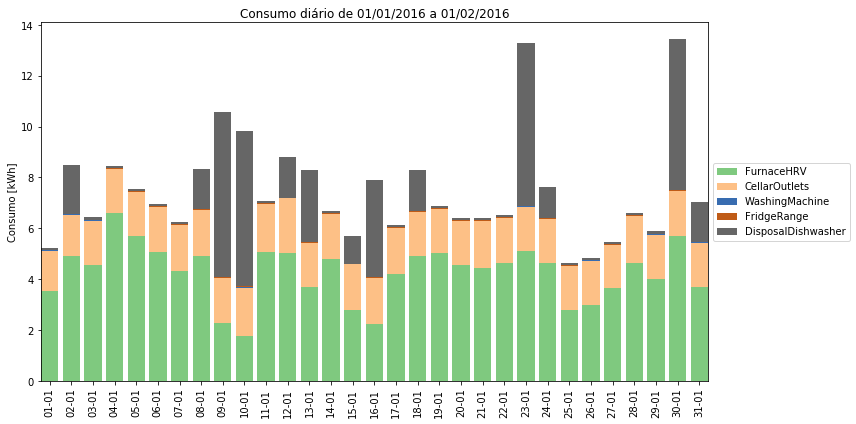

In [6]:
# Plot daily consumption for each channel for all period available
start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2016-02-01')
freq = 'D'
select_channels = [0, 1, 2, 3, 12]
#select_channels = range(len(channels))

fig, ax = plt.subplots()
cmap = plt.cm.Accent
colors = cmap(np.linspace(0., 1., len(select_channels)))
bottom = 0
for i in range(len(select_channels)):
    query = qry_cons_channel(select_channels[i], start_date, end_date, frequency=freq)
    
    # Convert query string to pandas.DataFrame
    ch = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
    ch.t = pd.to_datetime(ch.t)
    
    # Plot query results
    #plt.plot(ch.t, ch.energy, label=labels.iloc[i]['name'])
    if i == 0:
        plt.bar(ch.t.dt.strftime('%d-%m'), ch.energy, label=labels.iloc[i]['name'], color=colors[i])
    else:
        plt.bar(ch.t.dt.strftime('%d-%m'), ch.energy, label=labels.iloc[i]['name'], color=colors[i], bottom=bottom)
    bottom += np.array(ch.energy)

plt.ylabel('Consumo [kWh]')
plt.xticks(rotation=90)
plt.title('Consumo diário de {} a {}'.format(start_date.strftime("%d/%m/%Y"), end_date.strftime("%d/%m/%Y")))
plt.legend(loc='upper right')
plt.margins(x=0)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(12, 6)
plt.savefig('plot/visualizacao/mult_cons_bar.png')
plt.show()

# Consumo agregado total

A cédula a seguir demonstra o uso da função `qry_cons_aggr` para informar o consumo total no mês de janeiro de 2016.

É possível alterar o período a ser considerado por meio das variáveis `start_date` e `end_date`.

É possível alterar a frequência de medição (`'D'`, `'W'`, ou `'M'`) por meio da variável `freq`.

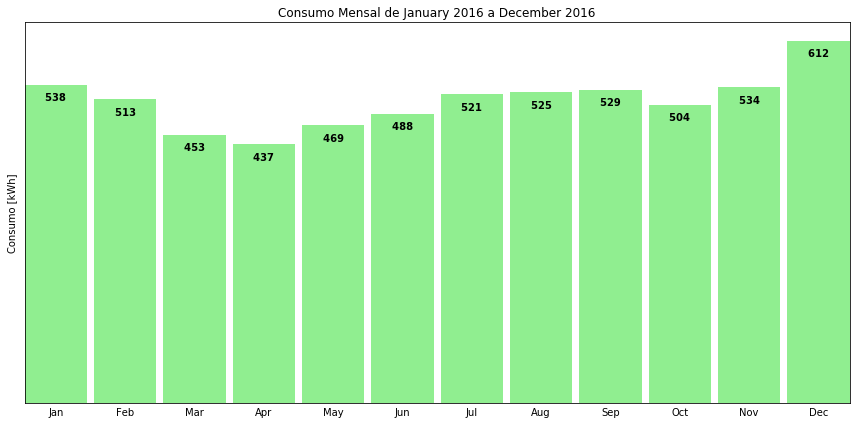

In [7]:
import calendar


def qry_cons_aggr(start, end, frequency):
    """Runs a query for the daily/weekly/monthly consumption [kWh] in all channels in the specified period.
    
    Args:
        start (str): start of the period as "YYYY-MM-DD hh:mm:ss".
        end (str): end of the period as "YYYY-MM-DD hh:mm:ss".
        frequency (str): Period of consumption. 'D', 'W', or 'M' (daily, weekly or monthly).
    
    Returns:
        str: csv of the query as [index, date, consumption].
    """
    
    t = pd.date_range(start, end, freq='M')
    cons = pd.DataFrame(0, index=np.arange(len(t)), columns=['cons'])
    aggr_cons = pd.DataFrame([t, cons]).transpose()
    aggr_cons.columns = ['t', 'energy']
    aggr_cons.t = pd.to_datetime(aggr_cons.t)
    aggr_cons.energy = 0
        
    for i_channel in range(len(channels)):
        # Select the desired period from channel
        ch = channels[i_channel]
        mask = (ch.t >= start) & (ch.t < end)
        ch_period = ch.loc[mask]

        # Find mean consumption by day, week, or month
        cons = ch_period.copy()
        cons = cons.set_index('t')
        cons = cons.groupby(pd.Grouper(freq=frequency)).mean().dropna(how='all')
        cons = cons.reset_index()
        cons = pd.concat([cons.t, cons.pot], axis=1)
        cons.columns = ['t', 'energy']
        cons.fillna(0)
        
        # Convert to kWh
        period_hours = 24
        if frequency == 'W':
            period_hours *= 7
        if frequency == 'M':
            period_hours *= 30  # TODO: considerar meses com 29 ou 31 dias
        cons.energy = cons.energy * period_hours / 1e3
        
        aggr_cons['energy'] += cons.energy
    
    # Return query as csv string
    return aggr_cons.to_csv()


# Plot daily consumption for each channel for all period available
start_date = pd.to_datetime('2016-01')
end_date = pd.to_datetime('2016-12-31')
freq = 'M'

# Convert query string to pandas.DataFrame
query = qry_cons_aggr(start_date, end_date, freq)
cons = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
cons.t = pd.to_datetime(cons.t)

# Plot query results
fig, ax = plt.subplots()
plt.title('Consumo Mensal de {} a {}'.format(start_date.strftime("%B %Y"), end_date.strftime("%B %Y")))
month_names = cons.t.dt.month.apply(lambda x: calendar.month_abbr[x])  # convert month numbers to names
plt.bar(month_names, cons.energy, width=0.9, color='lightgreen')
plt.ylabel('Consumo [kWh]')
ax.set_yticklabels([])  # hide tick labels
ax.tick_params(axis=u'both', which=u'both',length=0)  # hide tick marks
plt.margins(x=0)  # remove white space

# Add values at the top of each bar
rects = ax.patches
bar_labels = ["{:5.0f}".format(cons.iloc[i].energy) for i in range(len(rects))]
for rect, label in zip(rects, bar_labels):
    height = rect.get_height()
    ax.text(rect.get_x() - 0.05 + rect.get_width()/2, height - 30, label,
            ha='center', va='bottom', weight = 'bold')

fig.set_size_inches(12, 6)
plt.savefig('plot/visualizacao/aggr_monthly.png')
plt.show()

# Participação de cada canal no consumo total

A cédula a seguir demonstra o uso da função `qry_total_cons_all` para informar a participação de cada canal no consumo do mês de janeiro de 2016.

É possível alterar o período a ser considerado por meio das variáveis `start_date` e `end_date`.

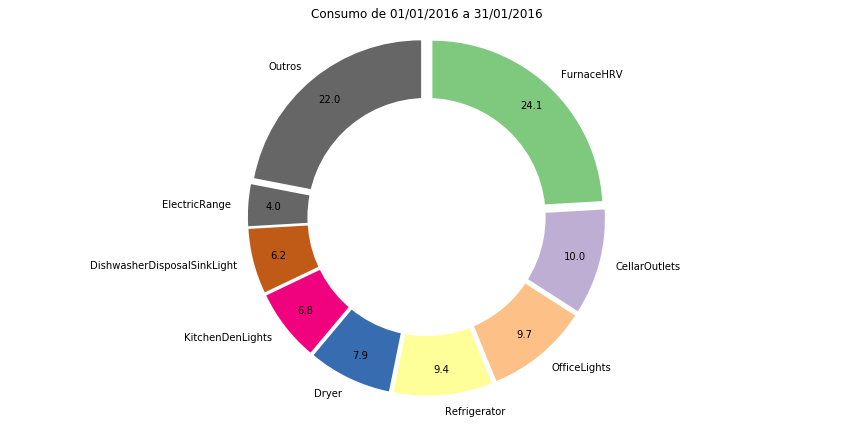

<Figure size 432x288 with 0 Axes>

In [8]:
def qry_total_cons_all(start, end, percentage=False):
    """Runs a query for the total consumption in each channel in the specified period.
    
    Args:
        start (str): start of the period as "YYYY-MM-DD hh:mm:ss".
        end (str): end of the period as "YYYY-MM-DD hh:mm:ss".
        percentage (bool): if true, return percentage of total consumption of each channel.
    
    Returns:
        str: csv of the query as [label; total consumption].
    """
    total_cons = {}
    for i in range(0, len(channels)):
        # Select the desired period from channel
        ch = channels[i]
        mask = (ch.t >= start) & (ch.t < end)
        ch_period = ch.loc[mask]
        
        # Find mean consumption
        cons = ch_period.pot.mean()
        
        # Convert to kWh
        t1 = pd.to_datetime(start)
        t2 = pd.to_datetime(end)
        cons *= pd.Timedelta(t2 - t1).total_seconds() / (1e3 * 3600)
        
        # Add total consumption of channel i to hash map
        appliance_name = labels.iloc[i]['name']
        if appliance_name != 'mains':
            if appliance_name not in total_cons:
                total_cons[appliance_name] = cons
            else:
                total_cons[appliance_name + '_1'] = total_cons.pop(appliance_name)
                total_cons[appliance_name + '_2'] = cons
    
    if percentage == True:
        sum = 0
        for key, value in total_cons.items():
            sum += value
        for key, value in total_cons.items():
            total_cons[key] /= sum
    
    sorted_cons = sorted(total_cons.items(), key=operator.itemgetter(1), reverse=True)
    
    result = ','.join([item[0] for item in sorted_cons]) + '\n'
    result += ','.join([str(item[1]) for item in sorted_cons])
    return result


start_date = pd.to_datetime('2016-01-01')
end_date = start_date + pd.to_timedelta('30 days')
query = qry_total_cons_all(start_date, end_date, percentage=True)

f = StringIO(query)
qry_reader = csv.reader(f, delimiter=',')
sorted_cons = []
for row in qry_reader:
    sorted_cons.append(row)

for i in range(len(sorted_cons[1])):
    sorted_cons[1][i] = float(sorted_cons[1][i])

max_channels = 8
sum_others = 0
for i in range(max_channels, len(sorted_cons[1])):
    sum_others += sorted_cons[1][i]

sorted_cons[0] = sorted_cons[0][:max_channels] + ['Outros']
sorted_cons[1] = sorted_cons[1][:max_channels] + [sum_others]

cmap = plt.cm.Accent
colors = cmap(np.linspace(0., 1., len(sorted_cons[0])))

fig1, ax1 = plt.subplots()

explode = [0.05] * (max_channels + 1)

#plt.figure(figsize=(100, 100))
plt.title('Consumo de {} a {}'.format(start_date.strftime("%d/%m/%Y"), end_date.strftime("%d/%m/%Y")))
ax1.pie(sorted_cons[1], labels=sorted_cons[0], startangle=90, counterclock=False, autopct='%.1f', colors=colors,
       pctdistance=0.85, explode = explode)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')
plt.tight_layout()
fig.set_size_inches(12, 6)
plt.show()
plt.savefig('plot/qry_total_cons_all/by_channel.png')

# Alerta de consumo acima do esperado

Na cédula a seguir, é apresenado um exemplo de alerta, sendo acionado quando o consumo diário atual é superior à média dos últimos 7 dias em 50%.

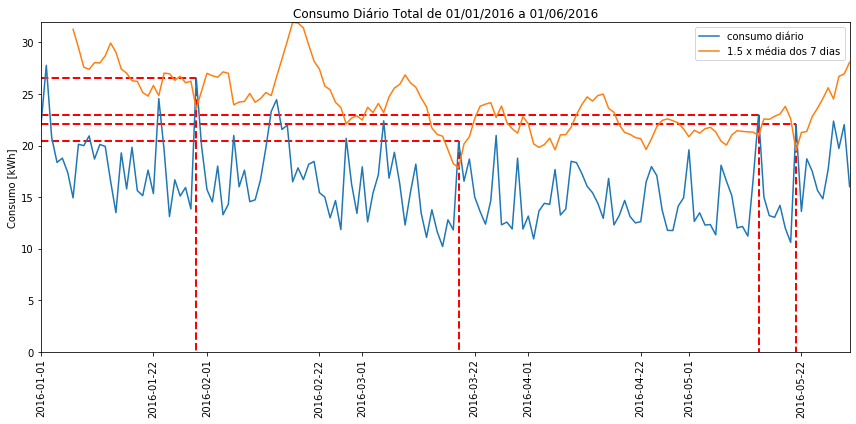

In [9]:
def qry_cons_aggr(start, end, frequency):
    """Runs a query for the daily/weekly/monthly consumption [kWh] in all channels in the specified period.
    
    Args:
        start (str): start of the period as "YYYY-MM-DD hh:mm:ss".
        end (str): end of the period as "YYYY-MM-DD hh:mm:ss".
        frequency (str): Period of consumption. 'D', 'W', or 'M' (daily, weekly or monthly).
    
    Returns:
        str: csv of the query as [index, date, consumption].
    """
    
    period_days = 1
    if frequency == 'W':
        period_days = 7
    if frequency == 'M':
        period_days = 30
    
    periods = (pd.to_datetime(end) - pd.to_datetime(start)).days / period_days
    t = pd.date_range(start, periods=periods, freq='{}D'.format(period_days))
    cons = pd.DataFrame(0, index=np.arange(periods), columns=['cons'])
    aggr_cons = pd.DataFrame([t, cons]).transpose()
    aggr_cons.columns = ['t', 'energy']
    aggr_cons.t = pd.to_datetime(aggr_cons.t)
    aggr_cons.energy = 0
        
    for i_channel in range(len(channels)):
        # Select the desired period from channel
        ch = channels[i_channel]
        mask = (ch.t >= start) & (ch.t < end)
        ch_period = ch.loc[mask]

        # Find mean consumption by day, week, or month
        cons = ch_period.copy()
        cons = cons.set_index('t')
        cons = cons.groupby(pd.Grouper(freq=frequency)).mean().dropna(how='all')
        cons = cons.reset_index()
        cons = pd.concat([cons.t, cons.pot], axis=1)
        cons.columns = ['t', 'energy']
        cons.fillna(0)
        
        # Convert to kWh
        period_hours = 24 * period_days
        cons.energy = cons.energy * period_hours / 1e3
        
        aggr_cons['energy'] += cons.energy
    
    # Return query as csv string
    return aggr_cons.to_csv()


# Plot daily consumption for each channel for all period available
start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2016-06-01')
freq = 'D'

# Convert query string to pandas.DataFrame
query = qry_cons_aggr(start_date, end_date, freq)
cons = pd.read_csv(StringIO(query), delimiter=',', header=0, usecols=[1, 2])
cons.t = pd.to_datetime(cons.t)

fig, ax = plt.subplots()

# Warn when consumption too high
avg_cons = []
alert_cons = []
alert_t = []
rows, _ = cons.shape
for i in range(6, rows):
    avg_cons.append(1.5 * cons[i-6:i].energy.mean())
    if cons.iloc[i].energy > avg_cons[-1]:
        alert_cons.append(cons.iloc[i].energy)
        alert_t.append(cons.iloc[i].t)
        plt.plot([cons.iloc[i].t, cons.iloc[i].t], [cons.iloc[i].energy, 0], linestyle='dashed', color='red',
                linewidth=2)
        plt.plot([cons.iloc[0].t, cons.iloc[i].t], [cons.iloc[i].energy, cons.iloc[i].energy], linestyle='dashed', color='red',
                linewidth=2)

# Plot query results
plt.plot(cons.t, cons.energy, label='consumo diário')
plt.plot(cons[6:].t, avg_cons, label='1.5 x média dos 7 dias')
plt.legend()
#plt.plot([alert_t[0], alert_t[0]], [0, alert_cons[0]])
plt.ylabel('Consumo [kWh]')
plt.xticks(rotation=90)
plt.title('Consumo Diário Total de {} a {}'.format(start_date.strftime("%d/%m/%Y"), end_date.strftime("%d/%m/%Y")))
plt.margins(x=0)
plt.margins(y=0)
fig.set_size_inches(12, 6)
plt.savefig('plot/visualizacao/aggr_daily.png')
plt.show()